In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Dropout,BatchNormalization,LSTM,Bidirectional,GlobalMaxPool1D,Input,Activation,Flatten,Embedding,Dense
import string
import re
from tqdm import tqdm
import contractions
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import spacy
from sklearn.model_selection import train_test_split
import os
from keras.models import Model
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from better_profanity import profanity
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [2]:
data=pd.read_csv("train-balanced-sarcasm.csv")
data.shape

FileNotFoundError: [Errno 2] No such file or directory: 'train-balanced-sarcasm.csv'

In [ ]:
data.head(5)

In [ ]:
data.info()

## Data Cleaning

label 1 is sarcastic and label 0 is not sarcastic

Counting the null values

In [4]:
null_values=data.isna().sum()
print(null_values)

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64


The comment column has 53 null values.We have dropped that values

In [5]:
data=data.dropna()
data.isna().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

Checking duplicate values

In [6]:
duplicate_values=data[data.duplicated()]
print("duplicate rows in the dataset",len(duplicate_values))
data.drop_duplicates(keep='first',inplace=True)

duplicate rows in the dataset 28


We can see that the score column has some erroneous values.

The score column is calculated as:Score=number of upvotes(ups)-number of downvotes(down)

In [7]:
data['score']=data['ups']-data['downs']

## Exploratory Data Analysis

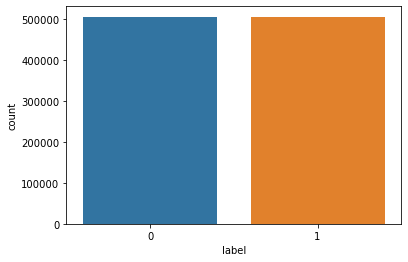

In [8]:
counts=data['label']
sns.countplot(x=counts)
plt.show()

We can see that our dataset is balanced as it has almost equal number of class labels

In [9]:
data.head(5)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,0,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,0,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,0,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,0,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [10]:
data.shape

(1010745, 10)

## Preprocessing text data for EDA

In [11]:
# slangs
strings='''AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
QPSA?=Que Pasa?
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher'''

In [12]:
x1=strings.split("\n")
dict1={}
for i in x1:
    x2=(i.split("="))
    dict1[x2[0]]=x2[1]
print(dict1)

{'AFAIK': 'As Far As I Know', 'AFK': 'Away From Keyboard', 'ASAP': 'As Soon As Possible', 'ATK': 'At The Keyboard', 'ATM': 'At The Moment', 'A3': 'Anytime, Anywhere, Anyplace', 'BAK': 'Back At Keyboard', 'BBL': 'Be Back Later', 'BBS': 'Be Back Soon', 'BFN': 'Bye For Now', 'B4N': 'Bye For Now', 'BRB': 'Be Right Back', 'BRT': 'Be Right There', 'BTW': 'By The Way', 'B4': 'Before', 'CU': 'See You', 'CUL8R': 'See You Later', 'CYA': 'See You', 'FAQ': 'Frequently Asked Questions', 'FC': 'Fingers Crossed', 'FWIW': "For What It's Worth", 'FYI': 'For Your Information', 'GAL': 'Get A Life', 'GG': 'Good Game', 'GN': 'Good Night', 'GMTA': 'Great Minds Think Alike', 'GR8': 'Great!', 'G9': 'Genius', 'IC': 'I See', 'ICQ': 'I Seek you (also a chat program)', 'ILU': 'ILU: I Love You', 'IMHO': 'In My Honest/Humble Opinion', 'IMO': 'In My Opinion', 'IOW': 'In Other Words', 'IRL': 'In Real Life', 'KISS': 'Keep It Simple, Stupid', 'LDR': 'Long Distance Relationship', 'LMAO': 'Laugh My A.. Off', 'LOL': 'Laug

In [13]:
def chat(text):
    new_text=[]
    for word in text.split():
        if word.upper() in dict1:
            new_text.append(dict1[word.upper()])
        else:
            new_text.append(word)
            
    done=" ".join(new_text)

            
    return done


            

In [21]:
data['comment']=data['comment'].apply(chat)

In [11]:
#decontract words
def decontracted(phrase):
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [12]:
data['comment']=data['comment'].apply(decontracted)

In [13]:
# lower case
data['comment']=data['comment'].str.lower()

In [14]:
# removing stopwords

# we have removed stopwords like no,not,nor.
stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
            "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", 
            "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", 
            "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
            "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but",
            "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", 
            "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", 
            "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", 
            "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few",
            "more", "most", "other", "some", "such" "only", "own", "same", "so", "than", "too", "very", 
            "s", "t", "can", "will", "just", "don", "should", "now"]

In [15]:
def stopwords1(text):
    new_list=[]
    for word in text.split():
        if word in stop_words:
            new_list.append("")
        else:
            new_list.append(word)

    done=list(filter(None,new_list))
    done=" ".join(done)
    
    return done

In [16]:
data['comment']=data['comment'].apply(stopwords1)

In [17]:
# remove html tags
def remove_html(text):
    return re.sub(r'<.*?>',"",text)

In [18]:
data['comment']=data['comment'].apply(remove_html)

In [19]:
# removing digits
def remove_numbers(text):
    return re.sub("\d+", "", text)
      

In [20]:
data['comment']=data['comment'].apply(remove_numbers)

We haven't removed exclamation mark and question mark as sarcastic comments has exclamation mark in them

In [21]:
string1=string.punctuation
string1=list(string1)
string1.remove('!')
string1.remove('?')
print(string1)

['"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [22]:
def remove_punctuation(data):
    for char in string1:
        if char in data:
            data=data.replace(char," ")
    return data

In [23]:
data['comment']=data['comment'].apply(remove_punctuation)

## Converting dataframes according to class label

In [24]:
data_sarcasm=data[data['label']==1]
data_non_sarcasm=data[data['label']==0]

print((data_sarcasm.shape),data_non_sarcasm.shape)

(505340, 10) (505405, 10)


Authors

Some authors have a definite style of writing. We call it as stylometric and personality feature.

The idea here is if sarcastic commments can be judged by the nature of individual.

We will see what set of people have written most sarcastic comments.

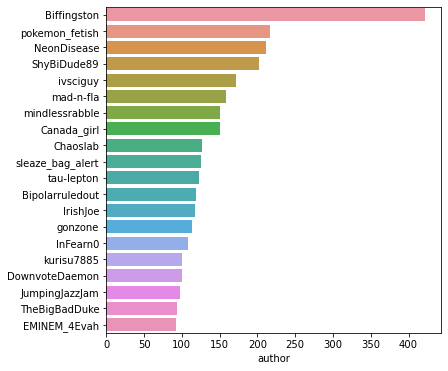

In [25]:
author_counts_sarcasm=data_sarcasm['author'].value_counts()[:20]
plt.figure(figsize=(6,6))
sns.barplot(x=author_counts_sarcasm,y=author_counts_sarcasm.index,data=data_sarcasm)
plt.show()

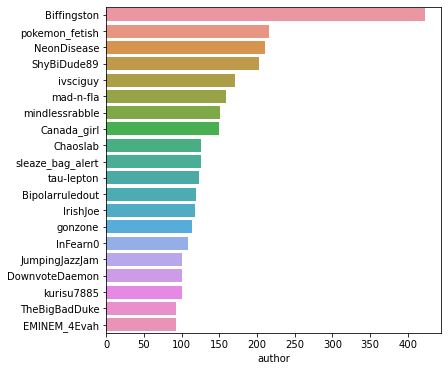

In [26]:
author_counts_non_sarcasm=data_non_sarcasm['author'].value_counts()[:20]
plt.figure(figsize=(6,6))
sns.barplot(x=author_counts_non_sarcasm,y=author_counts_non_sarcasm.index,data=data_non_sarcasm)
plt.show()

We can see that for both the labels the writer is almost same.


Subreddit

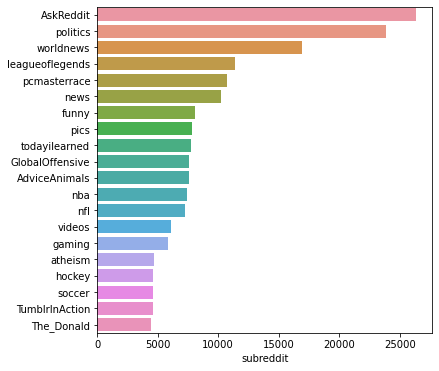

In [27]:
subreddidt_sarcasm=data_sarcasm['subreddit'].value_counts()[:20]
plt.figure(figsize=(6,6))
sns.barplot(x=subreddidt_sarcasm,y=subreddidt_sarcasm.index,data=data_sarcasm)
plt.show()

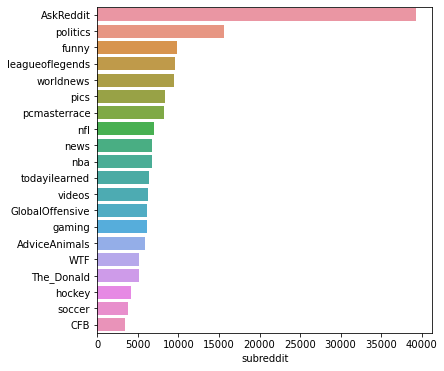

In [28]:
subreddidt_non_sarcasm=data_non_sarcasm['subreddit'].value_counts()[:20]
plt.figure(figsize=(6,6))
sns.barplot(x=subreddidt_non_sarcasm,y=subreddidt_non_sarcasm.index,data=data_non_sarcasm)
plt.show()

From above cells we can see that the topics for which sarcastic and non sarcastic comments are made are almost for same topics.

The politics category got the most sarcastic and non sarcastic comments.

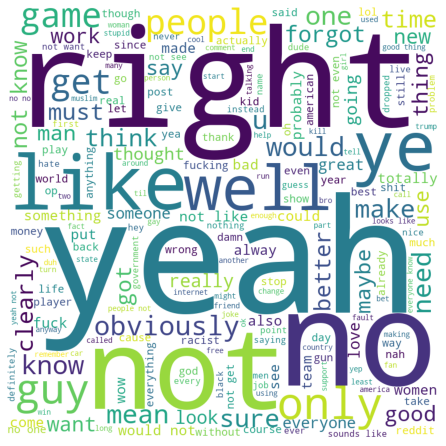

In [29]:
words=""
for sentence in data_sarcasm['comment']:
    tokens=(sentence.split())
    for i in range(len(tokens)):
        tokens[i]=tokens[i].lower()
    words +=" ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(words)

    # plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


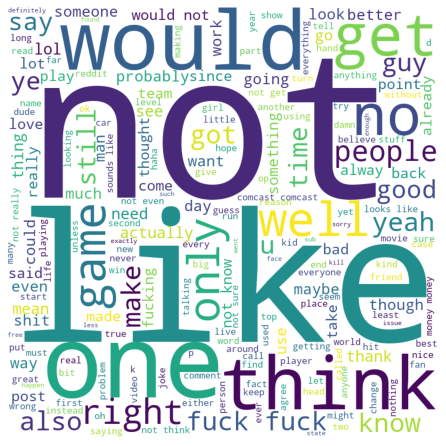

In [30]:
words=""
for sentence in data_non_sarcasm['comment']:
    tokens=(sentence.split())
    for i in range(len(tokens)):
        tokens[i]=tokens[i].lower()
    words +=" ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(words)

    # plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

From the above word cloud we can say that the words like(not,no,would,yeah etc) appears in both sarcastic and non sarcastic comments.

Average word length

In [31]:
def average_word_length(text):
    list2=[]
    for sentence in text:
        count=len(sentence)
        list2.append(count)
    avg_word_length=sum(list2)/len(text)
    
    return avg_word_length
    

In [32]:
print("average word length of sarcastic comments is",average_word_length(data_sarcasm['comment']))
print("average word length of non sarcastic comments is",average_word_length(data_non_sarcasm['comment']))

average word length of sarcastic comments is 38.49117030118336
average word length of non sarcastic comments is 38.864757966383394


There is no diiference in average word length pf sarcastic and non sarcastic comments

Average sentence length

In [33]:
def average_senetnce_length(text):
    sum1=0
    for sentence in text:
        count=len(sentence.split())
        sum1=sum1+count
        
    return (sum1/len(text))

In [34]:
print("average word length of sarcastic comments is",average_senetnce_length(data_sarcasm['comment']))
print("average word length of non sarcastic comments is",average_senetnce_length(data_non_sarcasm['comment']))

average word length of sarcastic comments is 5.963339533779238
average word length of non sarcastic comments is 6.017421671728614


There is no difference in between sentence length of sarcastic and non sarcastic comments

In [35]:
def frequent_top_words(dataframe):
    top_words=20
    frequent_words=dataframe.str.cat(sep="")
    words=nltk.word_tokenize(frequent_words)
    frequency_disb=nltk.FreqDist(words)
    
    return frequency_disb.most_common(top_words)
    

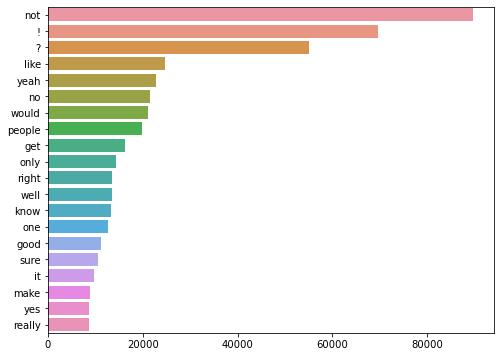

In [36]:
freq_sarcasm=frequent_top_words(data_sarcasm['comment'])
list1,list2=[],[]
for i,j in (freq_sarcasm):
    list1.append(i)
    list2.append(j)

plt.figure(figsize=(8,6))
sns.barplot(y=list1,x=list2)
plt.show()

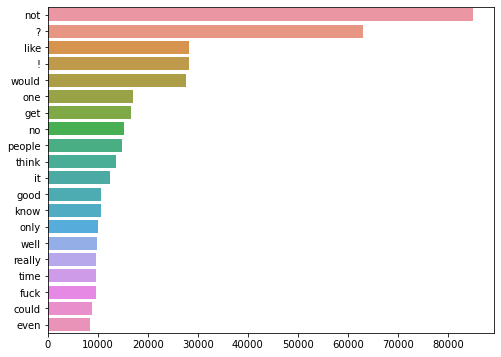

In [37]:
freq_non_sarcasm=frequent_top_words(data_non_sarcasm['comment'])
list1,list2=[],[]
for i,j in (freq_non_sarcasm):
    list1.append(i)
    list2.append(j)

plt.figure(figsize=(8,6))
sns.barplot(y=list1,x=list2)
plt.show()

The top 20 words are somewhat same for both sarcastic and non sarcastic comments

In [38]:
def count_exclamation(text):
    sum1=0
    for i in text:
        if '!' in i:
            sum1=sum1+1
    return sum1

In [39]:
print("number of sarcasm_exclamation is",count_exclamation(data_sarcasm['comment']))
print("number of non_sarcasm_exclamation is",count_exclamation(data_non_sarcasm['comment']))

number of sarcasm_exclamation is 69040
number of non_sarcasm_exclamation is 27811


We can see there is vast difference in exclamation mark in sarcastic and non sarcastic comments.

Exclamation mark can be a good feature for differntiating between sarcastic and non sarcastic comments.

In [42]:
def count_question(text):
    sum1=0
    for i in text:
        if '?' in i:
            sum1=sum1+1
    return sum1

In [43]:
print("number of sarcasm_question is",count_question(data_sarcasm['comment']))
print("number of non_sarcasm_question is",count_question(data_non_sarcasm['comment']))

number of sarcasm_question is 55014
number of non_sarcasm_question is 62842


We can see there is small difference in question mark in sarcastic and non sarcastic comments.

Question mark can be a feature for differntiating between sarcastic and non sarcastic comments.

## Univariate Analysis

Score column analysis

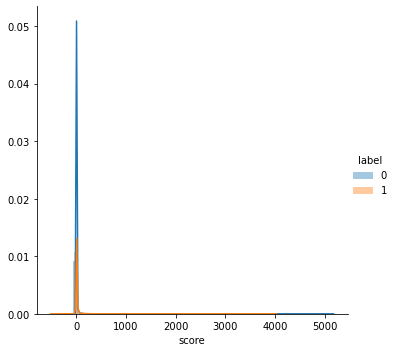

In [44]:
# code taken from the iris EDA

sns.FacetGrid(data, hue="label", size=5) \
   .map(sns.distplot, "score") \
   .add_legend();
plt.show();

We can see that score are overlapping for both sarcastic and non sarcastic comments.

We can see that scores are 0 for most of the datapoints in both labels.

Upvote column analaysis

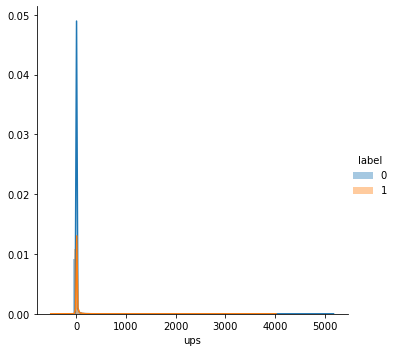

In [45]:
sns.FacetGrid(data, hue="label", size=5) \
   .map(sns.distplot, "ups") \
   .add_legend();
plt.show()

We can see that upvotes for sarcastic is 4000 and for non sarcastic it is 5000

Most of the upvotes are overlapping to each other

Downvote column analysis

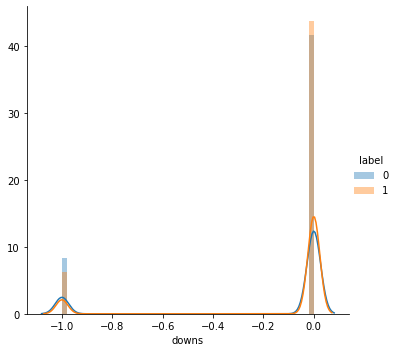

In [46]:
sns.FacetGrid(data, hue="label", size=5) \
   .map(sns.distplot, "downs") \
   .add_legend();
plt.show();

We can see that there is some negative value for both class labels.It means people have downvoted comment they don't like.

There is overlapping for both sarcastic comments and non sarcastic comments.

## Feature enginnering

In [86]:
def profanity_words(text):
    list1=[]
    for sentence in tqdm(text):
        profane_word=profanity.contains_profanity(sentence)
        list1.append(profane_word)
        
    return list1

In [ ]:
data_profanity_words=profanity_words(data['comment'])
# 100%|██████████| 1010745/1010745 [5:13:11<00:00, 53.79it/s]

In [ ]:
data_profane=pd.DataFrame(data_profanity_words)
data_profane.to_csv('data_profaned.csv')

In [94]:
def sentiment_subjectivity(text):
    list1=[]
    for sentence in tqdm(text):
        subjectivity=TextBlob(sentence).sentiment.subjectivity
        list1.append(subjectivity)
    return list1

In [95]:
data_sentiment_subj=(sentiment_subjectivity(data['comment']))

100%|██████████████████████████████████████████████████████████████████████| 1010745/1010745 [02:02<00:00, 8270.13it/s]


In [120]:
def sentiment_intensity(text):
    neg_list,pos_list,neutral_list=[],[],[]
    for sentence in tqdm(text):
        sentiment_object= SentimentIntensityAnalyzer()
        polarity_scores=sentiment_object.polarity_scores(sentence)
        
        neg_list.append(polarity_scores['neg'])
        pos_list.append(polarity_scores['pos'])
        neutral_list.append(polarity_scores['neu'])
        
    return neg_list,pos_list,neutral_list
        
    

In [121]:
data_pos,data_neg,data_neu=sentiment_intensity(data['comment'])

100%|██████████████████████████████████████████████████████████████████████| 1010745/1010745 [2:54:54<00:00, 96.31it/s]


In [137]:
# data_positive=pd.DataFrame(data_pos)
# data_positive.to_csv('data_positive.csv')

# data_negative=pd.DataFrame(data_neg)
# data_negative.to_csv('data_neagtive.csv')

# data_neutral=pd.DataFrame(data_neu)
# data_neutral.to_csv('data_neutral.csv')

In [47]:
## Exclamation mark

def count_exclamation(text):
    list1=[]
    for i in text:
        if '!' in i:
            list1.append(1)
        else:
            list1.append(0)
            
    return list1

In [48]:
data_exclamation=count_exclamation(data['comment'])

In [49]:
## question mark

def count_question(text):
    list1=[]
    for i in text:
        if '?' in i:
            list1.append(1)
        else:
            list1.append(0)
            
    return list1

In [50]:
data_question_mark=count_question(data['comment'])

In [87]:
author_dict={}
author_names=list(data['author'].unique())
print(author_names[0:6])

['Trumpbart', 'Shbshb906', 'Creepeth', 'icebrotha', 'cush2push', 'only7inches']


In [91]:
for i in tqdm(author_names):
    mask=data['author']==i
    string1=(data[mask].comment)
    string1="".join(string1)
    author_dict[i]=string1


100%|████████████████████████████████████████████████████████████████████████| 256560/256560 [3:18:45<00:00, 21.51it/s]


In [97]:
author_dictionary_strings=pd.Series(author_dict).to_frame()

In [100]:
author_dictionary_strings.to_csv('author_dictionary.csv')